# Case-study: Impact of SAF attribute selection

In [1]:
# Get python executable for jupyter notebook
import sys
print(sys.executable)

/opt/homebrew/opt/python@3.11/bin/python3.11


In [64]:
!safinfer -h

usage: safinfer [-h] [-i DIR_IN] [-a ARCH] [-m MAP] [-p PROB] [-s SPARSEOPTS]
                [-o DIR_OUT] [-b BINDING_OUT] [-t TAXO_SCRIPT_LIB]
                [-T TOPOLOGY_OUT] [-r] [-L] [-f LOG_FILE] [-q SETTINGS]

options:
  -h, --help            show this help message and exit
  -i DIR_IN, --dir-in DIR_IN
  -a ARCH, --arch ARCH
  -m MAP, --map MAP
  -p PROB, --prob PROB
  -s SPARSEOPTS, --sparseopts SPARSEOPTS
  -o DIR_OUT, --dir-out DIR_OUT
  -b BINDING_OUT, --binding-out BINDING_OUT
  -t TAXO_SCRIPT_LIB, --taxo-script-lib TAXO_SCRIPT_LIB
  -T TOPOLOGY_OUT, --topology-out TOPOLOGY_OUT
  -r, --reconfigurable-arch
  -L, --log
  -f LOG_FILE, --log-file LOG_FILE
  -q SETTINGS, --settings SETTINGS
                        safinfer configuration file.


In [ ]:
!rm -f ref_output/new_arch.yaml ref_output/new_arch.yaml.* ref_output/bindings.yaml 
!safinfer -a ref_input/arch.yaml -s ref_input/sparseopts_C_lf.yaml -q ref_input/safinfer_settings_C_lf.yaml -o ref_output/ -L
!mv ref_output/new_arch.yaml.pretty ref_output/new_arch_C_lf.yaml.pretty
!mv ref_output/new_arch.yaml ref_output/new_arch_C_lf.yaml
!mv ref_output/bindings.yaml ref_output/bindings_C_bidir.yaml
!mv safinfer.log safinfer_C_lf.log

In [ ]:
!safmodel -h

In [66]:
!rm -f ref_output/new_arch.yaml ref_output/new_arch.yaml.*
!safinfer -a ref_input/arch.yaml -s ref_input/sparseopts_C_bidir.yaml -q ref_input/safinfer_settings_C_bidir.yaml -o ref_output/ -L
!mv ref_output/new_arch.yaml.pretty ref_output/new_arch_C_bidir.yaml.pretty
!mv ref_output/new_arch.yaml ref_output/new_arch_C_bidir.yaml
!mv safinfer.log safinfer_C_bidir.log

zsh:1: no matches found: ref_output/new_arch.yaml.*


- SAFinfer settings path: ref_input/safinfer_settings_C_bidir.yaml
logging: True
>> SAFinfer
:: Setup
:: => Done, setup
reconfigurable_arch: False
:: Taxonomic inference
- COMPLETE: microarchitecture inference
  => SUCCESS
- Dumping inferred SAF microarchitecture topology to ref_output/new_arch.yaml ...
:: => Done, taxonomic inference
<< Done, SAFinfer


In [135]:
import sys
!{sys.executable} -m pip install matplotlib seaborn

DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/warcio-1.7.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/cdx_toolkit-0.9.35.dev1+g5eddafc.d20230616-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 1.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


# Fake SAFModel

In [136]:
import safmodel
import core.helper as helper
from core.helper import info,warn,error
from core import safmodel_core as safcore, \
                 safmodel_io as safio, \
                 safinfer_io
import os
import dill, yaml
import copy
import sympy as sp
import core.model.CasCompat as cc_
import math
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Spoof CLI flag parsing

import sys

sys.argv = [
    'safmodel', # This is typically the script name
    '-T', 'ref_output/new_arch_C_bidir.yaml',
    '-a', 'ref_input/arch.yaml',
    '-s', 'ref_input/sparseopts_C_bidir.yaml',
    '-c', 'ref_input/compound_components.yaml',
    '-U', 'ref_input/safmodel_settings.yaml',
    '-r', 'ref_output/arch_w_SAF.yaml',
    '-k', 'ref_output/',
    '-L'
]

arch, \
taxo_uarch, \
sparseopts, \
comp_in, \
arch_out_path, \
comp_out_path, \
user_attributes, \
do_logging,\
log_fn, \
characterization_path_list, \
model_script_lib_list, \
taxo_script_lib_list = safio.parse_args()

safmodel.log_config(do_logging,log_fn)
safmodel.opening_remark()
safmodel.setup(taxo_script_lib_list,characterization_path_list,model_script_lib_list)

SAFmodel.

Parsing input files:
- netlist: ref_output/new_arch_C_bidir.yaml
- arch: ref_input/arch.yaml
- sparseopts: ref_input/sparseopts_C_bidir.yaml
- compound components (input): ['ref_input/compound_components.yaml']
- arch output path: ref_output/arch_w_SAF.yaml
- compound components path (output): ref_output/
- SAFModel settings path: ref_input/safmodel_settings.yaml
logging: True
>> SAFmodel
:: Setup


In [3]:
# Build scale inference problem

warn(":: Scale inference",also_stdout=True)
'''Build scale inference problem'''
scale_prob=safcore.build_scale_inference_problem(arch, sparseopts, taxo_uarch, user_attributes=user_attributes)

:: Scale inference
Building scale inference problem...
Building RegisteredEqualityComparator_bitwidth$(u) energy area latency table.: 100%|██████████| 7/7 [00:00<00:00, 162.32it/s]
- RegisteredEqualityComparator_bitwidth$(u) MSE energy error (symbolic vs numerical): 1.525611648803889e-31
- RegisteredEqualityComparator_bitwidth$(u) RNMSE energy error (numerical vs true): 8.4 %
- RegisteredEqualityComparator_bitwidth$(u) MSE area error (symbolic vs numerical): 9.707226444223633e-25
- RegisteredEqualityComparator_bitwidth$(u) RNMSE area error (numerical vs true): 2.6 %
Building RegisteredEqualityComparator_bitwidth$(u) energy area latency table.: 100%|██████████| 7/7 [00:00<00:00, 191.93it/s]
- RegisteredEqualityComparator_bitwidth$(u) MSE energy error (symbolic vs numerical): 1.525611648803889e-31
- RegisteredEqualityComparator_bitwidth$(u) RNMSE energy error (numerical vs true): 8.4 %
- RegisteredEqualityComparator_bitwidth$(u) MSE area error (symbolic vs numerical): 9.707226444223633e-

In [4]:
list(scale_prob.keys())

['symbols',
 'symbol_types',
 'constraints',
 'energy_objectives',
 'area_objectives',
 'yields',
 'primitive_models',
 'component_models',
 'buffer_action_tree',
 'component_energy_action_tree',
 'sub_action_graph',
 'global_objective',
 'global_energy_objective',
 'global_area_objective',
 'abstract_global_objective_expression',
 'area_multiplier_dict',
 'simplified_symbols',
 'simplified_symbol_types',
 'simplified_constraints',
 'user_attributes']

In [5]:
scale_prob['global_objective']

'(0.0238329184902302*TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_rw_thresh**3 - 0.005111680555555566*TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_rw_thresh**2*TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_ww_thresh - 0.03860355925925933*TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_rw_thresh**2*TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_out_rw_thresh - 0.111935355357537*TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_rw_thresh**2 + 0.00045430396341473*TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_rw_thresh*TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_ww_thresh**2 + 0.0113931816666667*TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_rw_thresh*TestArchitecture.Skipping_shared_buffer3_shared_buffer1.Intersec

In [6]:
scale_prob_filename = 'scale_prob.dill'
simplified_constraints_filename = 'simplified_constraints.txt'
simplified_symbols_filename = 'simplified_symbols.txt'
simplified_symbol_types_filename = 'simplified_symbol_types.txt'
global_objective_filename = 'global_objective_file.yaml'
#area_objectives_filename = 'area_objectives_file.yaml'

# Dumping scale problem structure

import dill
# Open the file in binary write mode and save the variable
with open(scale_prob_filename, 'wb') as file:
    dill.dump(scale_prob, file)

print(f"Variable 'scale_prob' has been saved to {scale_prob_filename}")

# Dumping 

# Assuming scale_prob is your dictionary and 'simplified_constraints' is the key
simplified_constraints = scale_prob['simplified_constraints']
simplified_symbols = scale_prob['simplified_symbols']
simplified_symbol_types = scale_prob['simplified_symbol_types']
global_objective = scale_prob['global_objective']
#area_objectives = scale_prob['area_objectives']

# Specify the filename for the text file


# Constraints
with open(simplified_constraints_filename, 'w') as file:
    for constraint in simplified_constraints:
        file.write(constraint + '\n')

# Symbols
with open(simplified_symbols_filename, 'w') as file:
    for symbol in simplified_symbols:
        file.write(symbol + '\n')

# Symbol types
with open(simplified_symbol_types_filename, 'w') as file:
    for symbol_type in simplified_symbol_types:
        file.write(symbol_type + '\n')

import yaml
# Energy objectives dump
with open(global_objective_filename, 'w') as file:
    yaml.dump(global_objective, file)


#print(f"List 'simplified_constraints' has been saved to {simplified_symbol_types_filename}")


Variable 'scale_prob' has been saved to scale_prob.dill


## Routines which support modifying the constraint system

In [7]:
def load_lines_from_txt_file(filename):
    with open(filename, 'r') as file:
        return [line.strip() for line in file]
    
def load_objective_from_yaml_file(filename):
    with open(filename, 'r') as file:
        return yaml.safe_load(file)

In [8]:
def load_C_C_bidir_skip_constraint_system(modified_constraints_filename = "modified_constraints.txt"):
    scale_prob_filename = 'scale_prob.dill'
    modified_symbols_filename = "modified_symbols.txt"
    modified_symbol_types_filename = "modified_symbol_types.txt"
    modified_global_objective_filename = 'modified_global_objective_file.yaml'
    #modified_area_objectives_filename = 'modified_area_objectives_file.yaml'

    # Reload scale problem
    with open(scale_prob_filename, 'rb') as file:
        modified_scale_prob = dill.load(file)

    # Load modified constraints
    with open(modified_constraints_filename, 'r') as file:
        modified_constraints = [line.strip() for line in file]

    # Load modified constraints
    with open(modified_symbols_filename, 'r') as file:
        modified_symbols = [line.strip() for line in file]

    # Load modified constraints
    with open(modified_symbol_types_filename, 'r') as file:
        modified_symbol_types = [line.strip() for line in file]

    '''
    with open(modified_global_objective_filename, 'r') as file:
        modified_global_objective = yaml.safe_load(file)
    '''

    # Overwrite symbols
    modified_scale_prob['simplified_symbols'] = modified_symbols

    # Overwrite symbol tyeps
    modified_scale_prob['simplified_symbol_types'] = modified_symbol_types

    # Overwrite constraints list in scale problem
    modified_scale_prob['simplified_constraints'] = modified_constraints

    # Overwrite energy objectives
    # modified_scale_prob['global_objective'] = modified_global_objective

    return modified_scale_prob

In [9]:
def augment_constraint_system(scale_prob,additional_constraints):
    scale_prob['simplified_constraints']=scale_prob['simplified_constraints']+additional_constraints
    #print(scale_prob['simplified_constraints'])
    return scale_prob

In [10]:
def update_scale_prob_for_scenario(scenario_dir,scenario_constraints,add_new_symbols=False,ignore_scenario=False,modified_constraints_filename = "modified_constraints.txt"):
    modified_scale_prob = load_C_C_bidir_skip_constraint_system(modified_constraints_filename=modified_constraints_filename)
    additional_constraints = []
    transfer_relations = []
    if not ignore_scenario:
        #print("Loading scenario transfer relations")
        transfer_relations = load_lines_from_txt_file(os.path.join(scenario_dir,"transfer_relations.txt"))
        #for reln in transfer_relations:
            #print(reln)
    global_objective = load_objective_from_yaml_file(os.path.join(scenario_dir,"global_objective_file.yaml"))
    new_symbols = []
    new_symbol_types = []
    if add_new_symbols:
        new_symbols = load_lines_from_txt_file(os.path.join(scenario_dir,"symbols.txt"))
        new_symbol_types = load_lines_from_txt_file(os.path.join(scenario_dir,"symbol_types.txt"))

        #print("New symbols:")
        #print(new_symbols)
        #print("New symbol types:")
        #print(new_symbol_types)
    #print("Intersection additional constraints:")
    additional_constraints = transfer_relations+scenario_constraints
    #for cnstr in additional_constraints:
        #print(cnstr)
    modified_scale_prob = augment_constraint_system(modified_scale_prob,additional_constraints)
    modified_scale_prob['global_objective'] = global_objective
    modified_scale_prob['simplified_symbols'] = modified_scale_prob['simplified_symbols'] + new_symbols
    modified_scale_prob['simplified_symbol_types'] = modified_scale_prob['simplified_symbol_types'] + new_symbol_types
    return modified_scale_prob

In [11]:
def constraints_from_parameters(nc,sparsity_fraction0,sparsity_fraction1,ww,max_rw_ww_ratio,force_rw_max,pgen_out_thrpt):
    recip_density0 = str(1/(1-sparsity_fraction0))
    recip_density1 = str(1/(1-sparsity_fraction1))
    res = [
            "TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_nc == "+str(nc),
            "TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in1_nc == "+str(nc),
            "TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_ww == "+str(ww),
            "TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in1_ww == "+str(ww)
        ]

    if force_rw_max:
        res.extend([
            "TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_rw == "+str(ww*max_rw_ww_ratio),
            "TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in1_rw == "+str(ww*max_rw_ww_ratio)
        ])
    else:
        res.extend([
            "TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_rw <= "+str(ww*max_rw_ww_ratio),
            "TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in1_rw <= "+str(ww*max_rw_ww_ratio),
            "TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_rw >= "+str(ww),
            "TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in1_rw >= "+str(ww)
        ])

    return res

## Scenario

## Helper functions

In [41]:
def get_objective_and_transfer_relations(scenario_dir):
    #scenario_dir="C_C_bidir_direct_mapped" # C_C_bidir_direct_mapped, C_C_bidir_skip_ahead, C_C_bidir_two_finger

    #print("Loading scenario transfer relations")
    transfer_relations = load_lines_from_txt_file(os.path.join(scenario_dir,"transfer_relations.txt"))
    print(transfer_relations)
    #print("Loading global objective")
    global_objective = load_objective_from_yaml_file(os.path.join(scenario_dir,"global_objective_file.yaml"))
    #print(global_objective)
    
    # Generate sympy-safe expressions
    safe_transfer_relation_strs = [cc_.create_safe_constraint(trln_str) for trln_str in transfer_relations]
    safe_transfer_relation_strs_sparsities = \
        [safe_trln_str.replace( \
            "( TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_pr )/( TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_cr )", \
                "TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_density_fraction0").replace( \
            "( TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in1_pr )/( TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in1_cr )", \
                "TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_density_fraction1").replace( \
            "TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_out_pr", \
            "TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_out_pr_per_stage"
                ) \
                for safe_trln_str in safe_transfer_relation_strs]
    safe_transfer_relations_sp = [sp.sympify(safe_trln_str) for safe_trln_str in safe_transfer_relation_strs_sparsities]
    safe_global_objective_str = cc_.create_safe_constraint(global_objective)
    safe_global_objective_sp = sp.sympify(safe_global_objective_str)

    return safe_transfer_relations_sp, safe_global_objective_sp

In [70]:
def create_lambda_functions(safe_transfer_relations_sp, TestArch):
    # Define symbols for the arguments
    nc, sparsity_fraction0, sparsity_fraction1, md_in_vectorization = sp.symbols('nc sparsity_fraction0 sparsity_fraction1 md_in_vectorization')

    subs_mapping = {
        'TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_out_vectorization': 1,
        'TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_nc': nc,
        'TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_density_fraction0': 1.0 - sparsity_fraction0,
        'TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_density_fraction1': 1.0 - sparsity_fraction1,
        'TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_vectorization': md_in_vectorization
    }

    lambdas = []
    for ineq in safe_transfer_relations_sp:
        # Sympify the inequality
        ineq_expr = sp.sympify(ineq)

        # Determine which side of the inequality contains TestArch
        bound_expr = ineq_expr.rhs if sp.Symbol(TestArch) in ineq_expr.lhs.free_symbols else ineq_expr.lhs

        #print(ineq_expr)
        #print(bound_expr)
        #print(bound_expr.subs(subs_mapping))

        # Create a lambda function with 'numpy' for fast numerical computation
        lambda_fn = sp.lambdify([nc, sparsity_fraction0, sparsity_fraction1, md_in_vectorization], bound_expr.subs(subs_mapping), modules=["numpy"])
        lambdas.append(lambda_fn)

    meta_lambda = \
        lambda nc_val,sparsity_fraction0_val,sparsity_fraction1_val,md_in_vectorization_val: \
            np.min([lambda_fn(nc_val, sparsity_fraction0_val, sparsity_fraction1_val, md_in_vectorization_val) for lambda_fn in lambdas])
    return meta_lambda

In [71]:
def solve_max_throughput_per_pipeline_stage(nc, \
                                            sparsity_fraction0, \
                                            sparsity_fraction1, \
                                            md_in_vectorization, \
                                            lambda_fn):
    
    return lambda_fn(nc, sparsity_fraction0, sparsity_fraction1, md_in_vectorization)

In [139]:
def create_objective_lambda(safe_global_objective_sp_dict,intersection_unit):
    # Define symbols for the arguments
    nc, sparsity_fraction0, sparsity_fraction1, md_in_vectorization, ww, nc_thresh, num_stages = sp.symbols('nc sparsity_fraction0 sparsity_fraction1 md_in_vectorization ww nc_thresh num_stages')

    # Retrieve and sympify the expression
    expr = sp.sympify(safe_global_objective_sp_dict[intersection_unit])
    
    # Extract symbols
    symbols_in_expr = expr.free_symbols

    # Define substitution mapping
    subs_mapping = {
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_out_vectorization'): num_stages,
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_nc'): nc,
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_density_fraction0'): 1.0 - sparsity_fraction0,
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_density_fraction1'): 1.0 - sparsity_fraction1,
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_vectorization'): md_in_vectorization,
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_ww_thresh'): ww,
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_out_nc_thresh'): nc_thresh
    }

    # Update subs_mapping to map any remaining symbols to 0
    for sym in symbols_in_expr:
        if sym not in subs_mapping:
            if 'IntersectionBD' not in str(sym):
                subs_mapping[sym] = 0
            else:
                print("Symbol "+str(sym)+" contains IntersectionBD")
                assert(False)

    # Apply substitutions
    pruned_expr = expr.subs(subs_mapping)
    print(pruned_expr)
    return sp.lambdify([nc, sparsity_fraction0, sparsity_fraction1, md_in_vectorization, ww, nc_thresh, num_stages], pruned_expr.subs(subs_mapping), modules=["numpy"])

In [72]:
def process_expression(safe_global_objective_sp_dict,intersection_unit, nc, sparsity_fraction0, sparsity_fraction1, md_in_vectorization, ww, nc_thresh):
    # Retrieve and sympify the expression
    expr = sp.sympify(safe_global_objective_sp_dict[intersection_unit])
    
    # Extract symbols
    symbols_in_expr = expr.free_symbols

    # Define substitution mapping
    subs_mapping = {
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_out_vectorization'): 1,
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_nc'): nc,
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_density_fraction0'): 1.0 - sparsity_fraction0,
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_density_fraction1'): 1.0 - sparsity_fraction1,
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_vectorization'): md_in_vectorization,
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_in0_ww_thresh'): ww,
        sp.Symbol('TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_out_nc_thresh'): nc_thresh
    }

    # Update subs_mapping to map any remaining symbols to 0
    for sym in symbols_in_expr:
        if sym not in subs_mapping:
            if 'IntersectionBD' not in str(sym):
                subs_mapping[sym] = 0
            else:
                print("Symbol "+str(sym)+" contains IntersectionBD")
                assert(False)

    # Apply substitutions
    pruned_expr = expr.subs(subs_mapping)

    # Evaluate to a floating point value
    pruned_safe_objective_float = float(pruned_expr)

    return pruned_safe_objective_float

In [227]:
def get_num_stages(target_thrpt,ideal_matches,real_matches_per_stage,md_in_vectorization):
    num_stages = math.ceil(target_thrpt/real_matches_per_stage)
    if target_thrpt > ideal_matches or num_stages > 2*md_in_vectorization:
        return False, None, None
    else:
        return True, num_stages, num_stages*real_matches_per_stage

## Get ideal match-count

## Main loop

In [228]:
intersection_units = ["C_C_bidir_direct_mapped","C_C_bidir_two_finger","C_C_bidir_skip_ahead"]

In [229]:
TestArch='TestArchitecture__Skipping_shared_buffer3_shared_buffer1__IntersectionBD__md_out_pr_per_stage'
safe_transfer_relations_sp_dict = {}
safe_global_objective_sp_dict = {}
lambda_dict = {}
obj_lambda_dict = {}

for isect in intersection_units:
    isect_safe_transfer_relations_sp, isect_safe_global_objective_sp = get_objective_and_transfer_relations(isect)
    safe_transfer_relations_sp_dict[isect]=isect_safe_transfer_relations_sp
    safe_global_objective_sp_dict[isect]=isect_safe_global_objective_sp
    lambda_dict[isect] = create_lambda_functions(isect_safe_transfer_relations_sp, TestArch)
    obj_lambda_dict[isect] = create_objective_lambda(safe_global_objective_sp_dict,isect)
print(lambda_dict)
print(obj_lambda_dict)

['( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_out_pr ) <= 0.0959369126156345*( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_out_vectorization )*(( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_nc )*( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_pr )/( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_cr ))**0.488237372753155*(( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_nc )*( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in1_pr )/( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in1_cr ))**0.52267185623028 + (1000*(( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_nc ) - 8)**2 + 1000*(( TestArchitecture.Skipping_shared_buffer3_shared_buffer1.IntersectionBD.md_in0_vectorization ) - 1)**2)/((( TestArchitecture.Skipping

In [314]:
ww=4

test_case_list=[
                    {'nc':nc,'md_in_vectorization':md_in_vectorization, \
                     'sparsity_fraction0':sparsity_fraction0, \
                     'sparsity_fraction1':sparsity_fraction1, \
                     'isect':isect, \
                     'target_thrpt':target_thrpt}
                    for target_thrpt in list(np.linspace(0.0, 2.0, 51)) \
                        for nc in [8, 16, 32] \
                            for md_in_vectorization in [1,2,4] \
#                                for sparsity_fraction0 in [0.3,0.4,0.5,0.6,0.7] \
#                                    for sparsity_fraction1 in [0.3,0.4,0.5,0.6,0.7] \
                                for sparsity_fraction0 in [0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98,0.99] \
                                    for sparsity_fraction1 in [0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98,0.99] \
                                        for isect in intersection_units
                ]
result_list=[]
ideal_max_value=None
isect_feasible=None
num_stages=None
mean_thrpt=None
for test_case in tqdm(test_case_list):
    nc=test_case['nc']
    md_in_vectorization=test_case['md_in_vectorization']
    sparsity_fraction0=test_case['sparsity_fraction0']
    sparsity_fraction1=test_case['sparsity_fraction1']
    isect=test_case['isect']
    target_thrpt=test_case['target_thrpt']

    isect_max_value = \
        solve_max_throughput_per_pipeline_stage(nc, \
                                                sparsity_fraction0, \
                                                sparsity_fraction1, \
                                                md_in_vectorization, \
                                                lambda_dict[isect])

    if isect=="C_C_bidir_direct_mapped":
        ideal_max_value = isect_max_value
        if ideal_max_value >= target_thrpt:
            isect_feasible=True
            num_stages=1
            mean_thrpt=ideal_max_value
        else:
            isect_feasible=False
            num_stages=None
            mean_thrpt=None
    else:
        isect_feasible,num_stages,mean_thrpt = get_num_stages(target_thrpt,ideal_max_value,isect_max_value,md_in_vectorization)

    obj_val=None
    if isect_feasible:
        obj_val=obj_lambda_dict[isect](nc, sparsity_fraction0, sparsity_fraction1, md_in_vectorization, ww, nc, num_stages) #process_expression(safe_global_objective_sp_dict,isect, nc, sparsity_fraction0, sparsity_fraction1, md_in_vectorization, ww, nc)

    test_case={'nc':nc, \
               'md_in_vectorization':md_in_vectorization, \
               'sparsity_fraction0':sparsity_fraction0, \
               'sparsity_fraction1':sparsity_fraction1, \
               'isect':isect, \
               'target_thrpt':target_thrpt
    }
    result={'isect_max_value':isect_max_value, \
            'isect_feasible':isect_feasible, \
            'num_stages':num_stages, \
            'mean_thrpt':mean_thrpt, \
            'obj_val':obj_val, \
            'test_case':test_case}
    result_list.append(result)

100%|██████████| 309825/309825 [00:03<00:00, 100461.09it/s]


In [315]:
def combine_test_cases_and_results(test_case_list, result_list):
    """
    Combines test cases and results into a single pandas DataFrame.

    Parameters:
    test_case_list (list of dict): List of test cases.
    result_list (list of dict): List of results corresponding to the test cases.

    Returns:
    pd.DataFrame: A DataFrame with combined test case and result data.
    """
    # Check if the lengths of the lists match
    if len(test_case_list) != len(result_list):
        raise ValueError("Length of test_case_list and result_list must be the same.")

    # Combine test cases and results into a single list of dictionaries
    combined_data = []
    for test_case, result in zip(test_case_list, result_list):
        combined_entry = {**test_case, **result}
        combined_data.append({k:combined_entry[k] for k in combined_entry if k!="test_case"})

    # Create a pandas DataFrame from the combined data
    df = pd.DataFrame(combined_data)

    # Replace None with NaN
    df.fillna(value=pd.NA, inplace=True)

    return df

In [316]:
df=combine_test_cases_and_results(test_case_list, result_list)

In [344]:
def filter_dataframe(df, nc_value, md_in_vectorization_value):
    """
    Filters the DataFrame for specific nc and md_in_vectorization values,
    where sparsity_fraction1 is greater than or equal to sparsity_fraction0,
    and isect_feasible is True.

    Parameters:
    df (pd.DataFrame): The DataFrame to be filtered.
    nc_value (int): The value of nc to filter for.
    md_in_vectorization_value (int): The value of md_in_vectorization to filter for.

    Returns:
    pd.DataFrame: A filtered DataFrame based on the given conditions.
    """
    filtered_df = df[
        (df['nc'] == nc_value) &
        (df['md_in_vectorization'] == md_in_vectorization_value) &
        (df['sparsity_fraction1'] == df['sparsity_fraction0']) &
        (df['isect_feasible'] == True)
    ]
    return filtered_df

In [345]:
filter_dataframe(df, 8, 4)

,nc,md_in_vectorization,sparsity_fraction0,sparsity_fraction1,isect,target_thrpt,isect_max_value,isect_feasible,num_stages,mean_thrpt,obj_val
1539,8,4,0.2,0.1,C_C_bidir_direct_mapped,0.00,2.409258,True,1.0,2.409258,675.073836
1540,8,4,0.2,0.1,C_C_bidir_two_finger,0.00,0.491297,True,0.0,0.000000,48.918615
1541,8,4,0.2,0.1,C_C_bidir_skip_ahead,0.00,0.762181,True,0.0,0.000000,1044.806160
1683,8,4,0.5,0.4,C_C_bidir_direct_mapped,0.00,1.344945,True,1.0,1.344945,675.073836
1684,8,4,0.5,0.4,C_C_bidir_two_finger,0.00,0.349705,True,0.0,0.000000,48.918615
...,...,...,...,...,...,...,...,...,...,...,...
299215,8,4,0.2,0.1,C_C_bidir_two_finger,1.96,0.491297,True,4.0,1.965188,822.502647
299216,8,4,0.2,0.1,C_C_bidir_skip_ahead,1.96,0.762181,True,3.0,2.286542,4345.712445
305289,8,4,0.2,0.1,C_C_bidir_direct_mapped,2.00,2.409258,True,1.0,2.409258,675.073836
305290,8,4,0.2,0.1,C_C_bidir_two_finger,2.00,0.491297,True,5.0,2.456485,2211.175936


In [346]:
df_filtered_thrpt = df[df['target_thrpt'] > 1]
df_filtered_thrpt

,nc,md_in_vectorization,sparsity_fraction0,sparsity_fraction1,isect,target_thrpt,isect_max_value,isect_feasible,num_stages,mean_thrpt,obj_val
157950,8,1,0.01,0.01,C_C_bidir_direct_mapped,1.04,0.777169,False,NaN,NaN,NaN
157951,8,1,0.01,0.01,C_C_bidir_two_finger,1.04,0.774517,False,NaN,NaN,NaN
157952,8,1,0.01,0.01,C_C_bidir_skip_ahead,1.04,0.764848,False,NaN,NaN,NaN
157953,8,1,0.01,0.02,C_C_bidir_direct_mapped,1.04,0.773056,False,NaN,NaN,NaN
157954,8,1,0.01,0.02,C_C_bidir_two_finger,1.04,0.770630,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
309820,32,4,0.99,0.98,C_C_bidir_two_finger,2.00,0.007489,False,NaN,NaN,NaN
309821,32,4,0.99,0.98,C_C_bidir_skip_ahead,2.00,0.016190,False,NaN,NaN,NaN
309822,32,4,0.99,0.99,C_C_bidir_direct_mapped,2.00,0.013115,False,NaN,NaN,NaN
309823,32,4,0.99,0.99,C_C_bidir_two_finger,2.00,0.005439,False,NaN,NaN,NaN


In [347]:
df_filtered_feasible = df[df['isect_feasible'] == False]
df_filtered_feasible

,nc,md_in_vectorization,sparsity_fraction0,sparsity_fraction1,isect,target_thrpt,isect_max_value,isect_feasible,num_stages,mean_thrpt,obj_val
6522,8,1,0.70,0.99,C_C_bidir_direct_mapped,0.04,0.039291,False,NaN,NaN,NaN
6523,8,1,0.70,0.99,C_C_bidir_two_finger,0.04,0.042796,False,NaN,NaN,NaN
6524,8,1,0.70,0.99,C_C_bidir_skip_ahead,0.04,0.039715,False,NaN,NaN,NaN
6567,8,1,0.80,0.99,C_C_bidir_direct_mapped,0.04,0.032234,False,NaN,NaN,NaN
6568,8,1,0.80,0.99,C_C_bidir_two_finger,0.04,0.034687,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
309820,32,4,0.99,0.98,C_C_bidir_two_finger,2.00,0.007489,False,NaN,NaN,NaN
309821,32,4,0.99,0.98,C_C_bidir_skip_ahead,2.00,0.016190,False,NaN,NaN,NaN
309822,32,4,0.99,0.99,C_C_bidir_direct_mapped,2.00,0.013115,False,NaN,NaN,NaN
309823,32,4,0.99,0.99,C_C_bidir_two_finger,2.00,0.005439,False,NaN,NaN,NaN


In [348]:
def plot_objective_vs_target_thrpt(df):
    """
    Plots objective value vs target throughput with different curves for each type
    of intersection unit and sparsity value, sorted by sparsity in the legend.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data to be plotted.
    """
    # Ensure the data is sorted by target_thrpt
    df = df.sort_values(by='target_thrpt')

    # Set the style and context for the plot
    sns.set(style="whitegrid")
    sns.set_context("talk")

    # Generate a list of markers to differentiate between intersection units
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']

    # Create a unique color for each sparsity value
    unique_sparsities = sorted(df['sparsity_fraction0'].unique())
    palette = sns.color_palette("hsv", len(unique_sparsities))

    # Plotting
    plt.figure(figsize=(10, 6))
    lines = {}  # Dictionary to hold line objects for custom legend
    for i, sparsity in enumerate(unique_sparsities):
        df_sparsity = df[df['sparsity_fraction0'] == sparsity]
        for j, isect in enumerate(df_sparsity['isect'].unique()):
            df_isect = df_sparsity[df_sparsity['isect'] == isect]
            line, = plt.plot(df_isect['target_thrpt'], df_isect['obj_val'], 
                             label=f'{isect}, Sparsity {sparsity}', 
                             color=palette[i], marker=markers[j % len(markers)], 
                             linestyle='-', markersize=8)
            lines[(sparsity, isect)] = line

    # Sort legend entries by sparsity and isect
    # Sort legend entries by sparsity and isect
    sorted_legend = sorted(lines.items(), key=lambda x: (x[0][0], x[0][1]))
    plt.legend([entry[1] for entry in sorted_legend], 
            [f'{isect}, Sparsity {sparsity}' for sparsity, isect in (entry[0] for entry in sorted_legend)],
            title='Intersection Unit, Sparsity', bbox_to_anchor=(1.05, 1), loc='upper left')


    # Adding title, and labels
    plt.title('Objective Value vs Target Throughput')
    plt.xlabel('Target Throughput')
    plt.ylabel('Objective Value')
    plt.tight_layout()

    # Show plot
    plt.show()

In [349]:
# df[df['isect_feasible'] == False]

df_filt=filter_dataframe(df, 16, 4)
df_filt

,nc,md_in_vectorization,sparsity_fraction0,sparsity_fraction1,isect,target_thrpt,isect_max_value,isect_feasible,num_stages,mean_thrpt,obj_val
3564,16,4,0.2,0.1,C_C_bidir_direct_mapped,0.00,2.024937,True,1.0,2.024937,960.121361
3565,16,4,0.2,0.1,C_C_bidir_two_finger,0.00,0.417913,True,0.0,0.000000,48.918615
3566,16,4,0.2,0.1,C_C_bidir_skip_ahead,0.00,0.696285,True,0.0,0.000000,1044.806160
3708,16,4,0.5,0.4,C_C_bidir_direct_mapped,0.00,1.241222,True,1.0,1.241222,960.121361
3709,16,4,0.5,0.4,C_C_bidir_two_finger,0.00,0.283963,True,0.0,0.000000,48.918615
...,...,...,...,...,...,...,...,...,...,...,...
301240,16,4,0.2,0.1,C_C_bidir_two_finger,1.96,0.417913,True,5.0,2.089566,2211.175936
301241,16,4,0.2,0.1,C_C_bidir_skip_ahead,1.96,0.696285,True,3.0,2.088855,4345.712445
307314,16,4,0.2,0.1,C_C_bidir_direct_mapped,2.00,2.024937,True,1.0,2.024937,960.121361
307315,16,4,0.2,0.1,C_C_bidir_two_finger,2.00,0.417913,True,5.0,2.089566,2211.175936


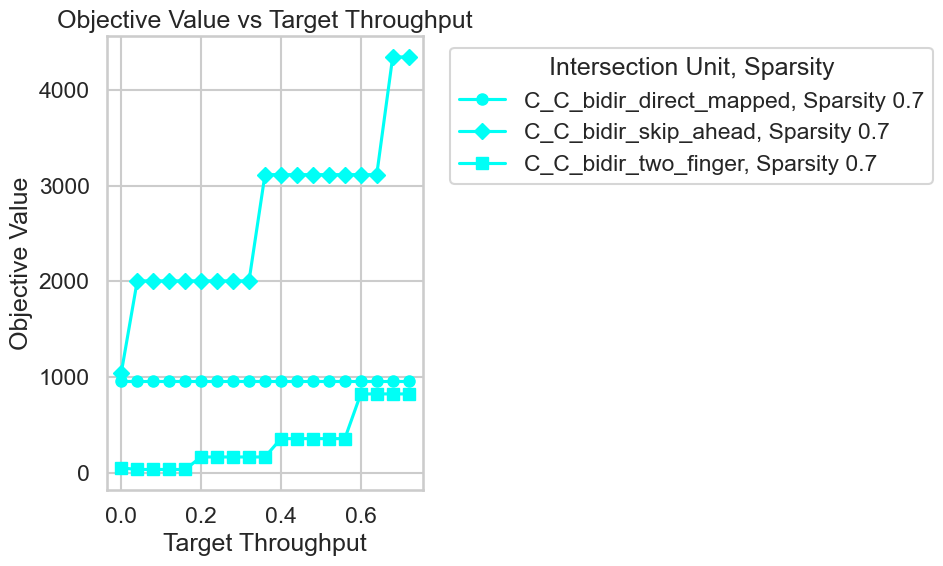

In [350]:
# df[df['isect_feasible'] == False]
plot_objective_vs_target_thrpt(df_filt[df_filt['sparsity_fraction0']==0.7])

In [351]:
def plot_objective_vs_sparsity(df):
    """
    Plots objective value vs sparsity with different curves for each target throughput value.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data to be plotted.
    """
    # Set the style and context for the plot
    sns.set(style="whitegrid")
    sns.set_context("talk")

    # Generate a list of colors to differentiate between target throughput values
    unique_thrpt_values = sorted(df['target_thrpt'].unique())
    palette = sns.color_palette("hsv", len(unique_thrpt_values))

    # Plotting
    plt.figure(figsize=(10, 6))

    for i, thrpt in enumerate(unique_thrpt_values):
        df_thrpt = df[df['target_thrpt'] == thrpt]
        plt.plot(df_thrpt['sparsity_fraction0'], df_thrpt['obj_val'], 
                 label=f'Target Thrpt {thrpt}', 
                 color=palette[i], marker='x', linestyle=':', markersize=8)

    # Adding legend, title, and labels
    plt.legend(title='Target Throughput', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Objective Value vs Sparsity')
    plt.xlabel('Sparsity')
    plt.ylabel('Objective Value')
    plt.grid(True)
    plt.tight_layout()

    # Show plot
    plt.show()

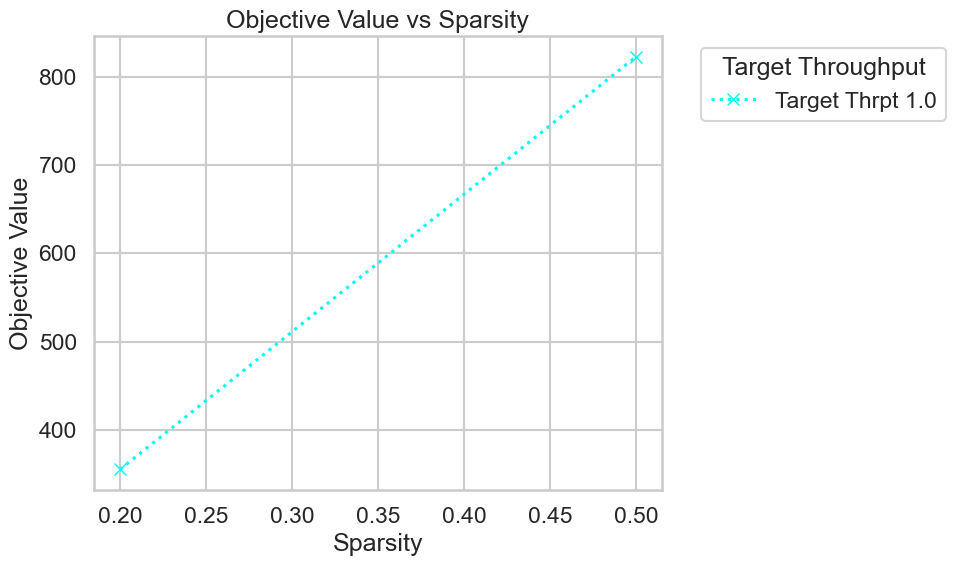

In [352]:
plot_objective_vs_sparsity(df_filt[(df_filt['target_thrpt']==1.0) & (df_filt['isect']=='C_C_bidir_two_finger')])

In [340]:
def plot_max_thrpt_vs_sparsity(df):
    """
    Plots the maximum target throughput vs sparsity for each intersection unit.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data to be plotted.
    """
    # Group by sparsity and intersection unit, then calculate max target_thrpt
    grouped = df.groupby(['sparsity_fraction0', 'isect'])['target_thrpt'].max().reset_index()

    # Set the style for the plot
    sns.set(style="whitegrid")
    sns.set_context("talk")

    # Create a color palette
    unique_isect = grouped['isect'].unique()
    palette = sns.color_palette("hsv", len(unique_isect))

    # Plotting
    plt.figure(figsize=(10, 6))

    for i, isect in enumerate(unique_isect):
        subset = grouped[grouped['isect'] == isect]
        plt.plot(subset['sparsity_fraction0'], subset['target_thrpt'],
                 label=isect, color=palette[i], marker='x', linestyle='-', markersize=8)

    # Adding legend, title, and labels
    plt.legend(title='Intersection Unit', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Maximum Target Throughput vs Sparsity')
    plt.xlabel('Sparsity')
    plt.ylabel('Max Target Throughput')
    plt.grid(True)
    plt.tight_layout()

    # Show plot
    plt.show()

# Usage:
# plot_max_thrpt_vs_sparsity(df)


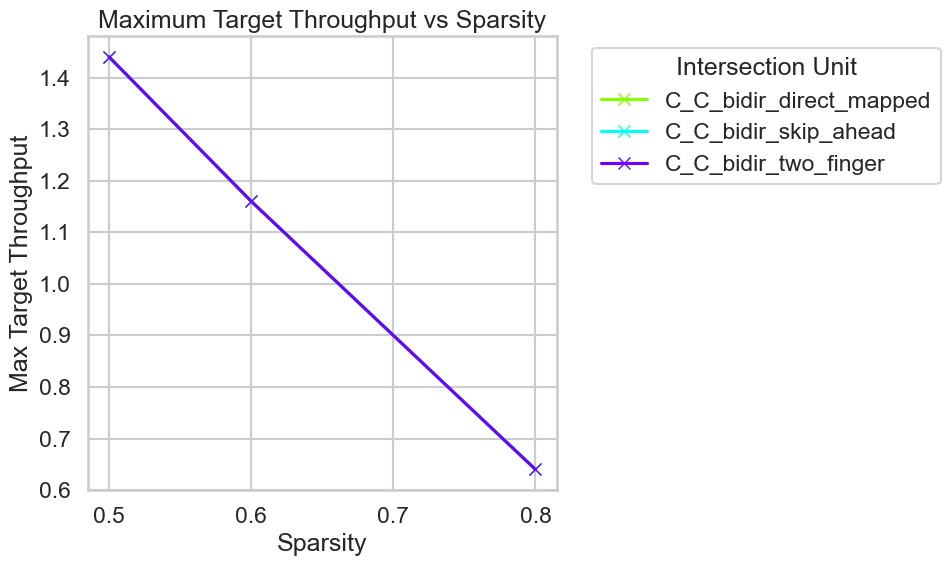

In [341]:
plot_max_thrpt_vs_sparsity(df_filt)

In [342]:
def plot_objective_vs_max_sparsity(df):
    """
    Plots objective value as a function of max sparsity for each intersection unit
    and target throughput value, sorted by objective value and connected with dotted lines.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data to be plotted.
    """
    # Set the style and context for the plot
    sns.set(style="whitegrid")
    sns.set_context("talk")

    # Generate a list of colors to differentiate between target throughput values
    unique_thrpt_values = sorted(df['target_thrpt'].unique())
    palette = sns.color_palette("hsv", len(unique_thrpt_values))

    # Generate a list of markers to differentiate between intersection units
    unique_isect = df['isect'].unique()
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'x']
    marker_dict = dict(zip(unique_isect, markers))

    # Plotting
    plt.figure(figsize=(10, 6))

    for i, thrpt in enumerate(unique_thrpt_values):
        df_thrpt = df[df['target_thrpt'] == thrpt]
        for isect in unique_isect:
            df_isect_thrpt = df_thrpt[df_thrpt['isect'] == isect]
            df_isect_thrpt_sorted = df_isect_thrpt.sort_values(by='obj_val')
            max_sparsity = df_isect_thrpt_sorted['sparsity_fraction0']
            obj_val = df_isect_thrpt_sorted['obj_val']
            plt.plot(max_sparsity, obj_val, 
                     color=palette[i], marker=marker_dict[isect], linestyle=':', markersize=8, label=f'{isect} (Thrpt {thrpt})')

    # Adding legend, title, and labels
    plt.legend(title='Intersection Unit, Target Throughput', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Objective Value vs Max Sparsity')
    plt.xlabel('Max Sparsity')
    plt.ylabel('Objective Value at Max Sparsity')
    plt.grid(True)
    plt.tight_layout()

    # Show plot
    plt.show()

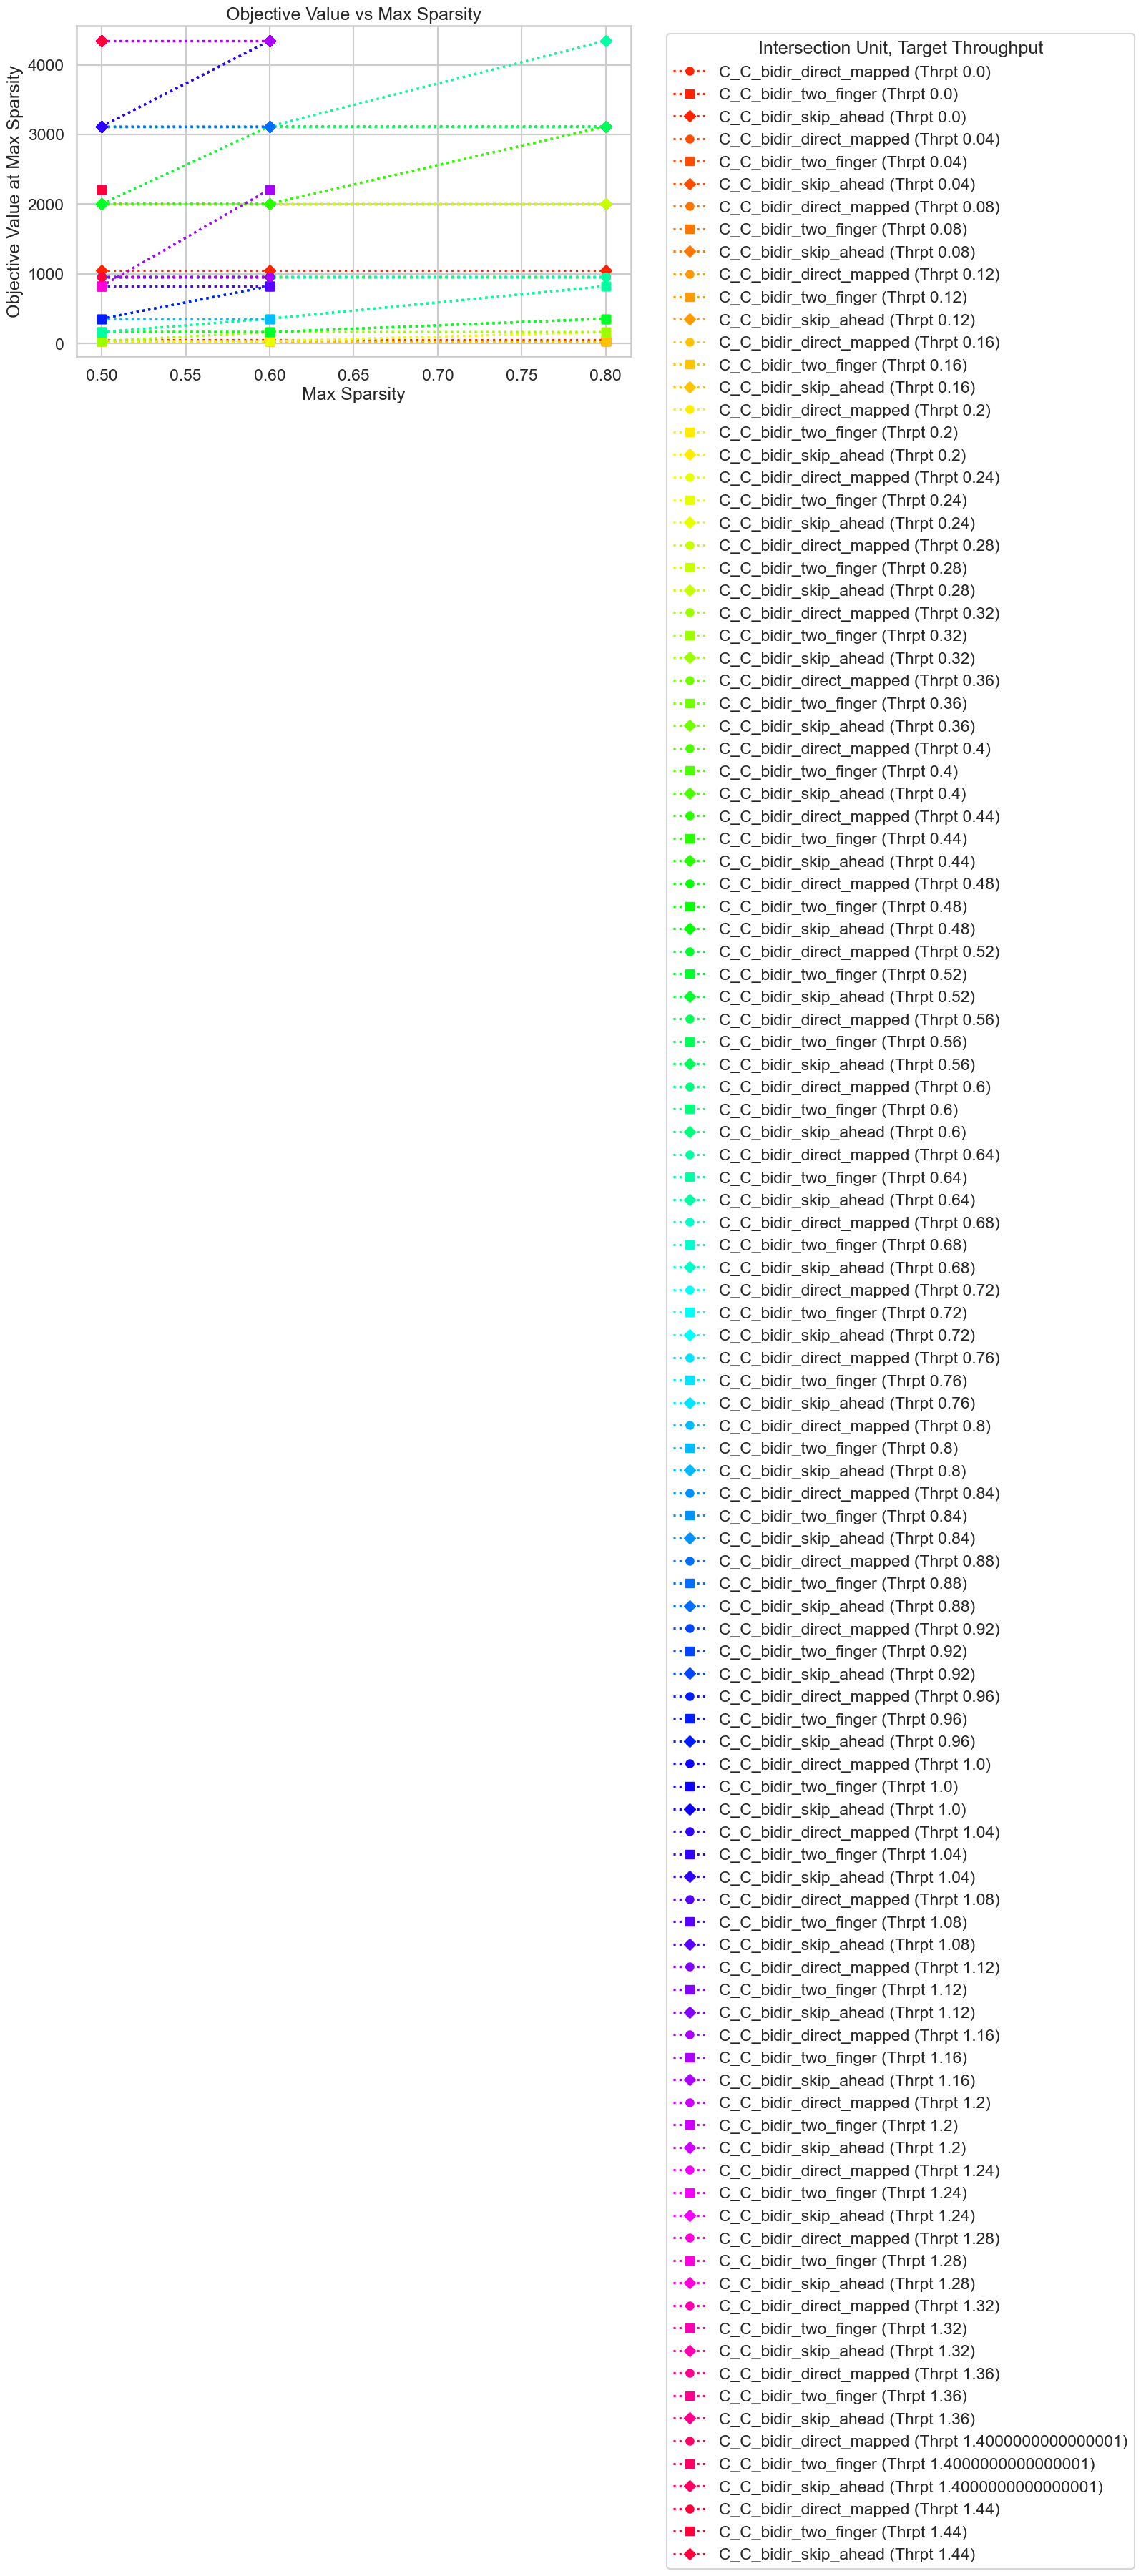

In [343]:
plot_objective_vs_max_sparsity(df_filt)

In [330]:
result_list

[{'isect_max_value': 0.7771687307901256,
  'isect_feasible': True,
  'num_stages': 1,
  'mean_thrpt': 0.7771687307901256,
  'obj_val': 45.311717926588486,
  'test_case': {'nc': 8,
   'md_in_vectorization': 1,
   'sparsity_fraction0': 0.01,
   'sparsity_fraction1': 0.01,
   'isect': 'C_C_bidir_direct_mapped',
   'target_thrpt': 0.0}},
 {'isect_max_value': 0.7745169350142368,
  'isect_feasible': True,
  'num_stages': 0,
  'mean_thrpt': 0.0,
  'obj_val': 54.025194794443514,
  'test_case': {'nc': 8,
   'md_in_vectorization': 1,
   'sparsity_fraction0': 0.01,
   'sparsity_fraction1': 0.01,
   'isect': 'C_C_bidir_two_finger',
   'target_thrpt': 0.0}},
 {'isect_max_value': 0.7648484089556491,
  'isect_feasible': True,
  'num_stages': 0,
  'mean_thrpt': 0.0,
  'obj_val': 100.69671368122275,
  'test_case': {'nc': 8,
   'md_in_vectorization': 1,
   'sparsity_fraction0': 0.01,
   'sparsity_fraction1': 0.01,
   'isect': 'C_C_bidir_skip_ahead',
   'target_thrpt': 0.0}},
 {'isect_max_value': 0.77305

## End

In [311]:
assert(False)

AssertionError: 

In [312]:
!rm ref_output/arch_w_SAF ref_output/arch_w_SAF_C_bidir.yaml ref_output/bindings_C_bidir.yaml
!safmodel -T ref_output/new_arch_C_bidir.yaml -a ref_input/arch.yaml -s ref_input/sparseopts_C_bidir.yaml -c ref_input/compound_components.yaml -U ref_input/safmodel_settings.yaml  -r ref_output/arch_w_SAF.yaml -k   ref_output/ -L
!mv ref_output/arch_w_SAF.yaml ref_output/arch_w_SAF_C_bidir.yaml
!mv safmodel.log safmodel_C_bidir.log

rm: ref_output/arch_w_SAF: No such file or directory
rm: ref_output/arch_w_SAF_C_bidir.yaml: No such file or directory
SAFmodel.

Parsing input files:
- netlist: ref_output/new_arch_C_bidir.yaml
- arch: ref_input/arch.yaml
- sparseopts: ref_input/sparseopts_C_bidir.yaml
- compound components (input): ['ref_input/compound_components.yaml']
- arch output path: ref_output/arch_w_SAF.yaml
- compound components path (output): ref_output/
- SAFModel settings path: ref_input/safmodel_settings.yaml
logging: True
>> SAFmodel
:: Setup
:: Scale inference
Building scale inference problem...
Building RegisteredEqualityComparator_bitwidth$(u) energy area latency table.: 1
- RegisteredEqualityComparator_bitwidth$(u) MSE energy error (symbolic vs numerical): 1.525611648803889e-31
- RegisteredEqualityComparator_bitwidth$(u) RNMSE energy error (numerical vs true): 8.4 %
- RegisteredEqualityComparator_bitwidth$(u) MSE area error (symbolic vs numerical): 9.707226444223633e-25
- RegisteredEqualityComparato

In [313]:
!rm ref_output/arch_w_SAF ref_output/arch_w_SAF_C_lf.yaml ref_output/bindings_C_lf.yaml
!safmodel -T ref_output/new_arch_C_lf.yaml -a ref_input/arch.yaml -s ref_input/sparseopts_C_lf.yaml -c ref_input/compound_components.yaml -U ref_input/safmodel_settings.yaml  -r ref_output/arch_w_SAF.yaml -k   ref_output/ -L
!mv ref_output/arch_w_SAF.yaml ref_output/arch_w_SAF_C_lf.yaml
!mv safmodel.log safmodel_C_lf.log

rm: ref_output/arch_w_SAF: No such file or directory
rm: ref_output/bindings_C_lf.yaml: No such file or directory
SAFmodel.

Parsing input files:
- netlist: ref_output/new_arch_C_lf.yaml
- arch: ref_input/arch.yaml
- sparseopts: ref_input/sparseopts_C_lf.yaml
- compound components (input): ['ref_input/compound_components.yaml']
- arch output path: ref_output/arch_w_SAF.yaml
- compound components path (output): ref_output/
- SAFModel settings path: ref_input/safmodel_settings.yaml
logging: True
>> SAFmodel
:: Setup
:: Scale inference
Building scale inference problem...
Building RegisteredEqualityComparator_bitwidth$(u) energy area latency table.: 1
- RegisteredEqualityComparator_bitwidth$(u) MSE energy error (symbolic vs numerical): 1.525611648803889e-31
- RegisteredEqualityComparator_bitwidth$(u) RNMSE energy error (numerical vs true): 8.4 %
- RegisteredEqualityComparator_bitwidth$(u) MSE area error (symbolic vs numerical): 9.707226444223633e-25
- RegisteredEqualityComparator_bitwidth$